In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
plt.rcParams['xtick.labelsize'] = 'medium'
plt.rcParams['ytick.labelsize'] = 'medium'
plt.rcParams['font.size'] = 14

# Bayesian statistics in action

We've seen the basics of Bayes law in the accompanying notes. A more general version of Bayes' original formulation of the law was in fact independently discovered in the early 1800s by Pierre Simon Laplace, who had not seen Bayes' posthumus publication.

Laplace applied his work on mathematical probabilities to the estimation of Saturn's mass; this was one of the first applications of Bayesian statistics and his result remains remarkably consistent with the present accepted value. 

In this notebook we will step through a Bayesian analysis of the very same measurement – however, for the sake of simplicity and retaining our focus on the statistics rather than the celestial mechanics, we will tackle a much simpler formulation of the problem than did Mr Laplace. 

We turn to the first measurement of Saturn's mass, undertaken by Sir Isaac Newton using Keplerian laws and measurements of Saturn's moon Titan: using the period and radius of Titan's orbit around Saturn, one can solve for the mass of Saturn.

In the following, we assume our measurements of Titan's orbital axis are much more precise than measurements of its orbital period – perhaps your timepiece is not very good. In practice, this means that for now we'll assume no error bars on the semi-major axis.

## How did Newton calculate $M_{Saturn}$?

Kepler's third law states that for any object orbiting a primary, the ratio of the square of the object's orbital period ($T$) and the cube of the semi-major axis ($a$) is constant. For example, all planets orbiting the sun have the same value of $T^2/a^3$.

With knowledge of Newton's Law of Gravitation, this ratio can be expressed in terms of the mass of the central ($M$) and orbiting ($m$) objects:

$$\frac{a^3}{T^2} = \frac{G(M+m)}{4\pi^2}$$

In the case of Titan orbiting Saturn, without knowing the mass of either object, it is clear that $m_{Titan}<<M_{Saturn}$, and so our (and Newton's!) simplifying assumption is that the mass of Titan can be dropped from the equation entirely. In this case we can easily solve for $M_{Saturn}$ in terms of the period and semi-major axis of Titan's orbit around Saturn:

$$M_{Saturn} = \frac{4\pi^2 a^3}{GT^2}$$

### Visualizing Newton's measurement

Let's code up these equations, simulate noisy measurements of the orbital period, and see what mass we measure for Saturn using the equation above.

In [2]:
G = 6.6743e-11 * (24*3600)**2  # m^3 per kg per day^2
a_titan = 1.22e9  # semi-major axis of Titan's orbit, in m

def measure_period(n=1, sigma=1):
    '''simulate measurement(s) of Titan's orbital period centered at the (modern) value 
    and with Gaussian measurement error sigma'''
    mean = 15.95
    return mean + np.random.normal(scale=sigma, size=n)
    
def calculate_saturn_mass(period):
    '''calculate saturn's mass using Newton's version of Kepler's third law'''
    num = 4 * np.pi**2 * a_titan**3
    denom = G * period**2
    return num / denom

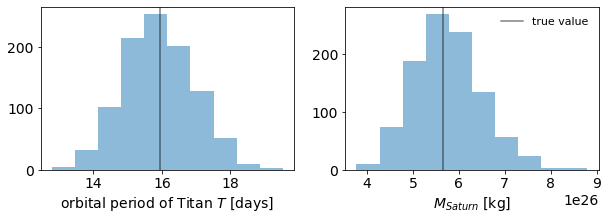

In [3]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,3))

period1000 = measure_period(n=1000)

ax1.hist(period1000, alpha=0.5)
ax1.axvline(15.95, color='k', alpha=.5)
ax1.set_xlabel('orbital period of Titan $T$ [days]')

ax2.hist(calculate_saturn_mass(period1000), alpha=0.5)
ax2.axvline(calculate_saturn_mass(15.95), color='k', alpha=.5, label='true value')
ax2.set_xlabel('$M_{Saturn}$ [kg]')
ax2.legend(fontsize=11, frameon=False)

plt.show;

In the figure above, we see a spread of values of Titan's orbit due to (simulated) measurement error. In the right hand panel we see those errors propogated into spread on the measured value of Saturn's mass. 

## Estimating $M_{Saturn}$ with Bayes

Above is one way to go between the measurement of orbital period to mass. Next, we use _Bayesian inference_ to measure the value of $M_{Saturn}$. 

### Why Bayesian analysis?

(should this section be in this notebook or in the notes??)

We won't enter the (extensive) debate on the merits of Bayesian vs frequentist methods here. However, here are a few points of motivation for the use of these, perhaps less intuitive, Bayesian inference methods:

- Proponents argue that using Bayes is the _natural_ way of thinking about inference problems. What does that mean? In the context of our mass measurement problem, the mass of Saturn in some sense _generates_ the value of Titan's orbital period. This dependence has a directionality, motivating us to mirror that in our statistical analysis; below, we will sample values of Saturn's mass and compare the resulting orbital period values with data to calculate the most probable value of mass, given some data (via the posterior distribution). 
- uncertainty quantification


### Steps for Bayesian inference

With this in mind, we forge ahead to performing the measurement. We will go through the following steps which are a rough guide to solving any inference problem:

1. write down a model and assumptions about the data/problem
2. write down a likelihood
3. choose a prior
4. use some method to find explore the posterior
5. quantify parameter estimates and uncertainties from the posterior

In many problems you might see later in your Bayesian career, step 4 might involve methods like Markov Chain Monte Carlo to sample possible values in parameter space and calculate the associated posterior. Here, we'll use a simple grid over parameter space – something which would rapidly become computationally infeasible for larger or more complex parameter spaces. 

### 1. Problem setup and assumptions about the data

The problem: given measurements of Titan's orbital period, estimate Saturn's mass.

#### Setup:
- parameter to infer is usually denoted $\theta$. Here $\theta = M_{Sat}$
- data: measured value of the period $T$
- model: a generative model for the data. Here orbital period ($T$) can be determined from a value of $\theta = M_{Sat}$ according to Newton/Kepler. We'll denote the model as $f(\theta)$ 

We've rearranged Newton's version of Kepler's third law to solve for period $T$ and coded it up in the cell below.

In [ ]:
def f(theta):
    '''given theta (saturn mass), return period'''
    num = 4 * np.pi**2 * d_sat**3
    denom = G * theta
    return np.sqrt(num / denom)

#### Assumptions: 
- we have a perfectly measured value of Titan's semi-major axis of rotation
- the measurement error on Titan's orbital period is Gaussian, with known spread $\sigma$

Below we 'measure' some data using fixed measurement error with $\sigma=1$. We generate a dataset of 50 measurements, and from this sample smaller datasets of $n=1$ and $n=5$.

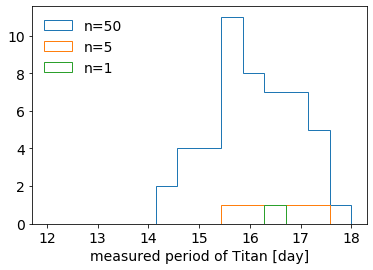

In [7]:
T_meas_50 = measure_period(n=50, sigma=1)
T_meas_1 = T_meas_50[:1]
T_meas_5 = T_meas_50[:5]

plt.hist(T_meas_50, bins=np.linspace(12,18,15), histtype='step', label='n=50')
plt.hist(T_meas_5, bins=np.linspace(12,18,15), histtype='step', label='n=5')
plt.hist(T_meas_1, bins=np.linspace(12,18,15), histtype='step', label='n=1')
plt.legend(frameon=False, loc=2)

plt.xlabel('measured period of Titan [day]')
plt.show()

### 2. Likelihood

We assumed that our measurements have Gaussian measurement error; another way of phrasing this assumption is that each measurement is drawn from a normal distribution which is centered around the true value with standard deviation $\sigma$. 
This is what we will use for our likelihood $p(T|\theta)$, with the truth represented by our model output $f(\theta)$:

$$ p(T|\theta) = \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{(T-f(\theta))^2}{ 2\sigma^2}} $$

In [28]:
def likelihood(T, theta, f, sigma):
    '''return likelihood. Assume T is normally distributed around the model f(theta)'''
    T = T[None,:]
    theta = theta[:,None]
    like_vector = 1 / (2 * np.pi * sigma**2) * np.exp(- (T - f(theta))**2 / (2 * sigma))
    return np.prod(like_vector, axis=1)

### 3. Choice of prior

We will explore possible values of $\theta$ and calculate the posterior at each of these values. Of course, we have some prior knowledge, that we encode into our _prior_ , that determine what range of these parameter values to explore. 

For example, we know that Saturn is a larger planet than Earth, and we know that it is smaller than the sun: we can set those masses as our lower and upper bounds. 

Within those limits, however, is each value as probable as the next? The prior will also encode the probability of each parameter value: another choice we must make. 

One option is to assign equal probability to every possible value (a uniform distribution). 
We will choose something similar (you are of course welcome to try out other options), but more suited to a problem which covers such a wide range of magnitudes – there are 5 orders of magnitude between the mass of the earth and the mass of the sun! We will use a prior which is uniform in the log, and assign equal probability to each point in _log space_. 

The choice of prior is visualized below.

In [6]:
log_m_earth = np.log10(6e24)
log_m_sun = 30

# set up a grid of 5000, uniformly spaced in log in our prior range
mass_grid = np.logspace(log_m_earth, log_m_sun, 5000)

# this function we will use later to calculate the prior probability of grid points
def prior(theta):
    '''log uniform prior on the mass of Saturn'''
    # usually a good idea to check that input theta is within  prior limits. here our grid will impose this
    return np.log10(theta) / theta

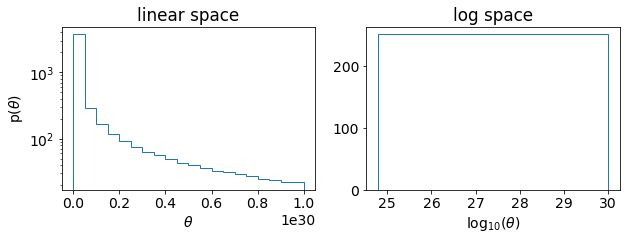

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))

ax[0].hist(mass_grid, bins=20, histtype='step')
ax[0].set_yscale('log')
ax[0].set_ylabel(r'p($\theta$)')
ax[0].set_xlabel(r'$\theta$')
ax[0].set_title('linear space')

ax[1].hist(np.log10(mass_grid), bins=20, histtype='step')
ax[1].set_xlabel(r'log$_{10}$($\theta$)')
ax[1].set_title('log space')

plt.show()

### 4. "explore" posterior: calculate the posterior for each point in the prior grid

The posterior is proportional the product of the prior and the likelihood: $p(\theta|data)\propto p(data|\theta)p(\theta)$

Because we believe our prior range contains all the probable values of $\theta$, we can normalize the posterior easily instead of calculating the denominator of Bayes law. 

In [8]:
def posterior(T, theta, f, sigma):
    '''return posterior: product of prior and likelihood. normalized.'''
    post = prior(theta) * likelihood(T, theta, f, sigma)
    return post / sum(post)

Use this function to calculate the posterior for a single one of the noisy measurements we generated above in 1.

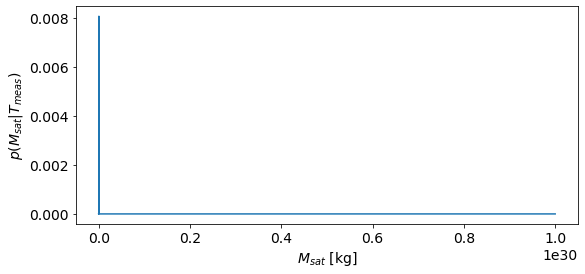

In [9]:
# calculate posterior for a single observation of Titan's period
post_1 = posterior(T_meas_1, mass_grid, f, sigma=1)

plt.figure(figsize=(9,4))
plt.plot(mass_grid, post_1)
plt.xlabel('$M_{sat}$ [kg]')
plt.ylabel('$p(M_{sat}|T_{meas})$');

This plot looks a bit off on first glance, but rest easy: we're showing the entire prior range on the x axis!  Let's narrow down on the region of non-zero probability, shown in the plot below. We can now see the nonzero posterior distribution in more detail. 

A reminder, this shows the probability of different values of $\theta=M_{Saturn}$ given our single data point of period.

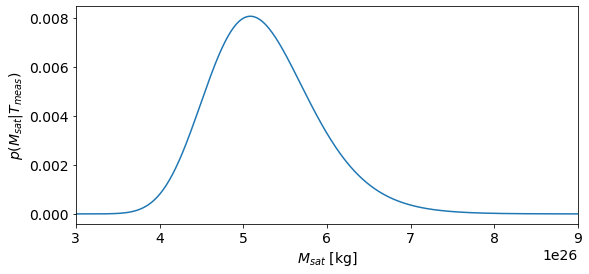

In [21]:
# Depending on the sample, you can tweak these limits to optimize the x axis range to see the whole posterior
narrowed_limits = [3e26,9e26]

plt.figure(figsize=(9,4))
plt.plot(mass_grid, post_1)
plt.xlim(narrowed_limits)
plt.xlabel('$M_{sat}$ [kg]')
plt.ylabel('$p(M_{sat}|T_{meas})$');

### 5. Quantify parameter estimate and uncertainty

Now that we have this nice posterior distribution, we want to report a single number (a "point estimate") with associated uncertainty ("credible interval") as a summary of our result. 

There are multiple valid ways to summarize a distribution in this way. Here we will use a simple one: the posterior median as a point estimate and 1$\sigma$ quantile as credible interval. A 1$\sigma$ quantile interval means we quote the mass interval which contains $68.2%$ of the posterior distribution, centered around the median. This will necessarily put equal weight in each tail of the distribution and thus works best for unimodal posteriors.

We'll do a cumulative numerical integral of the distribution and find the median and 1$\sigma$ quantiles from that. Note that most posterior exploration methods you'll use in the wild result in _samples_ from the posterior, in which case simply calling np.median(posterior) would do the trick.

In [17]:
import scipy.integrate

def ci_onesigma(posterior, grid): 
    '''function uses the posterior and grid to calculate the median, lower and upper 1 sigma quantiles. 
    Also return the grid positions of the quantiles.'''
    # integrate over the PDF to find the cumulative distribution
    cumulative_integral = scipy.integrate.cumtrapz(posterior, grid)
    cumulative_integral /= np.max(cumulative_integral)

    median_index = np.where(cumulative_integral>=0.5)[0][0]
    med = grid[median_index]

    # one sigma quantiles
    onesigma_qs = ((1.0-0.68268949)/2*np.array([1.,-1.])+np.array([0.,1.]))
    ql_index = np.where(cumulative_integral>=onesigma_qs[0])[0][0]
    qu_index = np.where(cumulative_integral>=onesigma_qs[1])[0][0]

    ql = grid[ql_index]
    qu = grid[qu_index]
    
    return med, ql, qu, median_index, ql_index, qu_index

Estimated mass of Saturn: 5.19e+26 with credible interval [4.62e+26,5.88e+26]


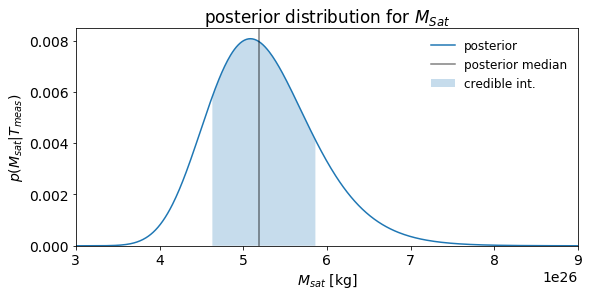

In [22]:
med1, q1l, q1u, *_ = ci_onesigma(post_1, mass_grid)
print(f'Estimated mass of Saturn: {med1:.3g} with credible interval [{q1l:.3g},{q1u:.3g}]')

plt.figure(figsize=(9,4))

plt.title('posterior distribution for $M_{Sat}$')
plt.plot(mass_grid, post_1, label='posterior')
plt.axvline(med1, color='k', alpha=0.5, label='posterior median')
plt.fill_between(mass_grid, post_1, where=(mass_grid>q1l)*(mass_grid<q1u), alpha=0.25, label='credible int.')
plt.legend(fontsize=12, frameon=False)
plt.xlim(narrowed_limits)
plt.ylim(0)
plt.xlabel('$M_{sat}$ [kg]')
plt.ylabel('$p(M_{sat}|T_{meas})$');

With a single measurement of Titan's period, we were able to constrain the mass of Saturn! What sets the precision of our estimate? The width of the posterior above depends on a few things such as our measurement error on the period, and the number of datapoints used. 

It's usually easier to add more measurements than to make more precise ones. This works nicely with the Bayesian idea of updating our beliefs (aka posterior) with new information (aka data). What happens as we add more and more measurements of the period to our posterior?

## Adding data points to analysis

Eq for likelihood as product of all terms

already coded the likelihood function to take a product, so we can just hand the function an array of values.

Below we'll use the arrays of $n=5$ and $n=50$ measurements to calculate a posterior:

Estimated mass of Saturn with n=1: 5.19e+26 with C.I. [4.62e+26,5.88e+26]
Estimated mass of Saturn with n=5: 5.79e+26 with C.I. [5.48e+26,6.14e+26]
Estimated mass of Saturn with n=50: 5.76e+26 with C.I. [5.65e+26,5.86e+26]


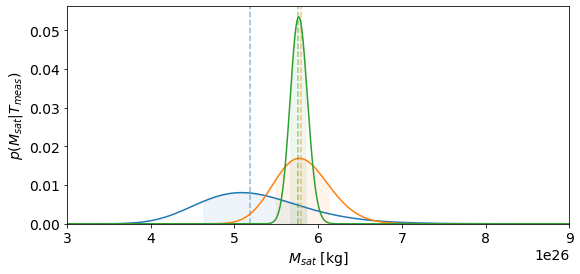

In [23]:
post_5 = posterior(T_meas_5, mass_grid, f, sigma=1)
post_50 = posterior(T_meas_50, mass_grid, f, sigma=1)

plt.figure(figsize=(9,4))
for i, p in enumerate([post_1, post_5, post_50],):
    color=[u'#1f77b4', u'#ff7f0e', u'#2ca02c'][i]
    med, ql, qu, med_loc, *_ = ci_onesigma(p, mass_grid)
    print(f'Estimated mass of Saturn with n={[1,5,50][i]}: {med:.3g} with C.I. [{ql:.3g},{qu:.3g}]')
    
    plt.plot(mass_grid, p, color=color)
    plt.axvline(med, color=color, linestyle='--', alpha=0.5)
    plt.fill_between(mass_grid, p, where=(mass_grid>ql)*(mass_grid<qu), color=color, alpha=0.075)

plt.xlim(narrowed_limits)
plt.ylim(0)
plt.xlabel('$M_{sat}$ [kg]')
plt.ylabel('$p(M_{sat}|T_{meas})$');

As we add additional datapoints we see the posterior distributions grow more narrow and more peaked, i.e. our estimate is more precise. This is captured also in the confidence intervals.

We also observe that the peak of the distribution can shift, especially going from 1 to 5 datapoints, due to the random measurement error. 

### To conclude 
There is much more to be said, which we will leave you to discover elsewere, about choosing priors, model selection, and quantifying uncertainty. 

In the next notebook, we continue our measurement of Saturn's mass, without the assumption we made here of perfect knowledge for the semi-major axis of Titan. How do the formulation and results change under additional uncertainty?

### References
- https://www.jstor.org/stable/41133763
- https://perfdynamics.blogspot.com/2013/09/laplace-bayesianista-and-mass-of-saturn.html
- https://medium.com/why-bother-with-space/how-do-we-know-the-mass-of-saturn-98fe3ce79632